## Final jupyter notebook 


### imports

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import os
# Limit threads to avoid MKL/OMP memory leak warnings on Windows before sklearn import
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import plotly.express as px
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### **EDA**


In [2]:
headshots = pd.read_csv("final_data_with_demographics.csv")
headshots.head()

,filename,name,email,race,gender,status,golden_score,face_ratio,mouth_nose_ratio,eye_ratio,face_height,face_width,nose_width,mouth_width
0,2025-Jon-Kropko_Sophie Kim.png,Jon Kropko,jkropko@virginia.edu,white/caucasian,male,Success,72.296905,1.265537,1.073991,2.378663,113.818867,89.937213,39.701984,42.639569
1,20250214_164859_Shawn Ding.jpg,Shawn Ding,NaN,asian,male,Success,65.385817,1.274937,0.840948,2.062060,575.460816,451.364018,176.880556,148.747304
2,7889B956-127B-4F16-8218-95F2EFBBB575_Sabine Se...,Sabine Segaloff,bhj3vc@virginia.edu,white/caucasian,female,Success,70.676671,1.229060,1.058037,2.332540,642.068678,522.406377,230.671558,244.059106
3,"Afriyie, Prince (pa5jg) square_Sophie Kim.png",Prince Afriyie,pa5jg@virginia.edu,black or african american,male,Success,69.104021,1.116233,1.119973,2.480829,107.956073,96.714640,43.573933,48.801633
4,Ana-Li MSDSR Ambassador_Anna Li.png,Anna Li,tpb3rw@virginia.edu,asian,female,Success,72.301283,1.200314,1.139356,2.402057,802.259079,668.374490,279.874979,318.877173


In [3]:
fig = px.scatter(
    headshots,
    x="face_ratio",
    y="mouth_nose_ratio",
    hover_name="name",
    hover_data=["name", 'race', 'gender'],
    height=650,
    title="K-Means Weather Clusters Across cohort"
)

fig.show()


In [4]:
headshots['gender'] = headshots['gender'].str.strip().str.lower()
headshots.gender.value_counts()
fig = px.histogram(headshots, x= 'race', color= 'gender',
                   barmode= 'group')
fig.update_layout(showlegend=False)
fig.show()

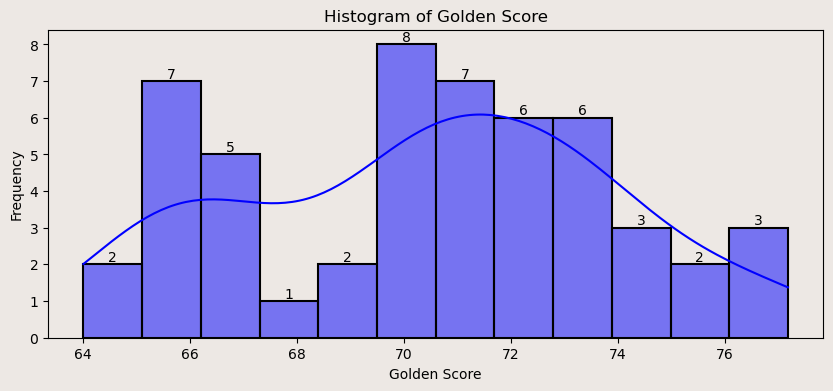

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4), facecolor='#ede8e4')
ax.set_facecolor('#ede8e4')

# histogram of the golden_score
sns.histplot(headshots['golden_score'], kde=True, color='blue', edgecolor='black', linewidth=1.5, bins=12)
plt.xlabel('Golden Score')
plt.ylabel('Frequency')
plt.title('Histogram of Golden Score')
plt.grid(False)

# count on top of each bar
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{int(p.get_height())}', ha='center', va='bottom')


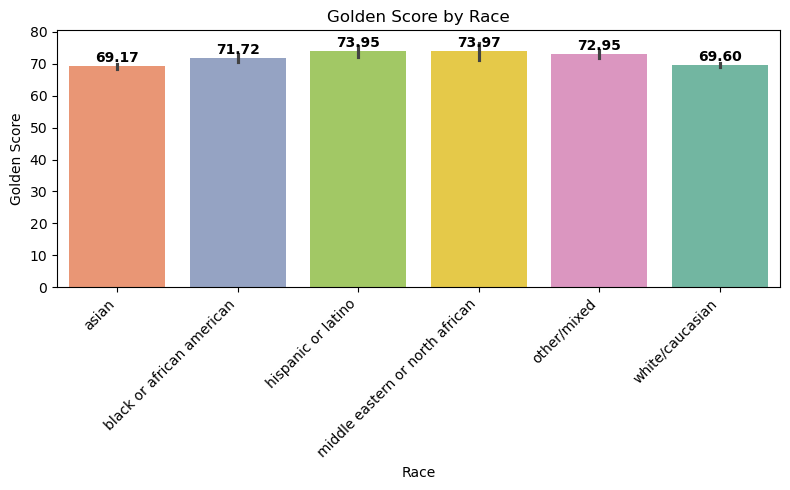

In [6]:
plt.figure(figsize=(8, 5))

race_order = sorted(headshots['race'].unique())

ax = sns.barplot(
    data=headshots,
    x='race',
    y='golden_score',
    hue='race',           
    order=race_order,
    palette='Set2',
    legend=False,        
    errorbar='se'
)

ax.set_xlabel('Race')
ax.set_ylabel('Golden Score')
ax.set_title('Golden Score by Race')

ax.set_xticks(range(len(race_order)))
ax.set_xticklabels(race_order, rotation=45, ha='right')

group_means = headshots.groupby('race')['golden_score'].mean()

for i, race in enumerate(race_order):
    y = group_means[race]
    ax.text(
        i, y + 0.5,
        f'{y:.2f}',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

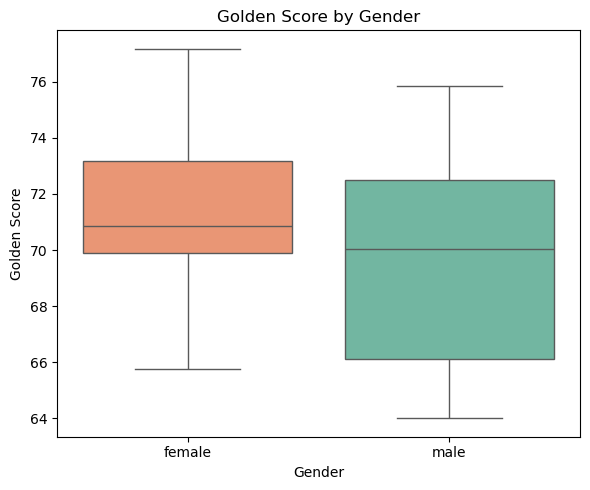

In [7]:
plt.figure(figsize=(6, 5))

gender_order = sorted(headshots['gender'].unique())

ax = sns.boxplot(
    data=headshots,
    x='gender',
    y='golden_score',
    order=gender_order,
    hue='gender',
    palette = 'Set2',
    showfliers=False   
)


ax.set_xlabel('Gender')
ax.set_ylabel('Golden Score')
ax.set_title('Golden Score by Gender')

ax.set_xticks(range(len(gender_order)))
ax.set_xticklabels(gender_order)

plt.tight_layout()
plt.show()


#############################################################################
# Linear Regression
#############################################################################

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px


predictive_cols = ['face_height', 'face_width', 'nose_width', 'mouth_width'] 

X = headshots[predictive_cols].copy()
y = headshots['golden_score'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5))
])

ridge_pipe.fit(X_train, y_train)
y_pred_test = ridge_pipe.predict(X_test)

R2_test = r2_score(y_test, y_pred_test)
RMSE_test = float(np.sqrt(mean_squared_error(y_test, y_pred_test)))


fig_fit_test = px.scatter(
    x=y_test,
    y=y_pred_test,
    labels={"x": "Actual golden_score", "y": "Predicted golden_score"},
    title="Multivariate Linear Model"
)

min_v = float(np.min([y_test.min(), y_pred_test.min()]))
max_v = float(np.max([y_test.max(), y_pred_test.max()]))


fig_fit_test.add_shape(
    type="line",
    x0=min_v, y0=min_v,
    x1=max_v, y1=max_v,
    line=dict(color="black", width=2, dash="dash"),
    name="Ideal: y = x")


#R² and RMSE
fig_fit_test.add_annotation(
    x=min_v, y=max_v,
    text=f"R²={R2_test:.3f} and RMSE={RMSE_test:.3f}",
    showarrow=False,
    font=dict(size=12, color="black"),
    xanchor="left", yanchor="top",
    bgcolor="white", opacity=0.8
)

fig_fit_test.show()

#############################################################################
### Logistic Regression
#############################################################################

In [9]:
## Create Target Variable: Golden Ratio Proximity Categories 


In [10]:
df = pd.read_csv('final_data_with_demographics.csv')


In [11]:
# Display the dataset with all calculations
print("\n" + "="*60)
print("Dataset with Golden Ratio Calculations:")
print("="*60)



Dataset with Golden Ratio Calculations:


In [12]:
display_cols = ['name', 'face_width', 'face_height', 'face_ratio', 
                'golden_score', 'golden_ratio_category', 
                'nose_to_face_ratio', 'mouth_to_face_ratio']

df_clean = df


In [13]:

df_clean.to_csv('logistic_model_dataset.csv', index=False)
df_clean = df.dropna(subset=['face_width', 'face_height', 'golden_score']).copy()


In [14]:

df_clean['face_ratio'] = df_clean['face_height'] / df_clean['face_width']
df_clean['nose_to_face_ratio'] = df_clean['nose_width'] / df_clean['face_width']
df_clean['mouth_to_face_ratio'] = df_clean['mouth_width'] / df_clean['face_width']

print("\nGolden Score statistics:")
print(df_clean['golden_score'].describe())
print(f"\nMin: {df_clean['golden_score'].min():.2f}")
print(f"Max: {df_clean['golden_score'].max():.2f}")



Golden Score statistics:
count    52.000000
mean     70.448369
std       3.452057
min      64.007132
25%      67.193261
50%      70.690606
75%      72.862851
max      77.171519
Name: golden_score, dtype: float64

Min: 64.01
Max: 77.17


In [15]:


q20 = df_clean['golden_score'].quantile(0.2)
q40 = df_clean['golden_score'].quantile(0.4)
q60 = df_clean['golden_score'].quantile(0.6)
q80 = df_clean['golden_score'].quantile(0.8)

def categorize_golden_score(score):
    """Categorize golden_score into 5 bins using quantile-based thresholds"""
    if score < q20:
        return 'Very Far'
    elif score < q40:
        return 'Far'
    elif score < q60:
        return 'Moderate'
    elif score < q80:
        return 'Close'
    else:
        return 'Very Close'

df_clean['golden_ratio_category'] = df_clean['golden_score'].apply(categorize_golden_score)


In [16]:

# Display distribution
print("\n" + "="*60)
print("Distribution of golden ratio categories:")
print("="*60)
print(df_clean['golden_ratio_category'].value_counts().sort_index())
print("\nProportions:")
print(df_clean['golden_ratio_category'].value_counts(normalize=True).sort_index())

print("\n" + "="*60)
print("Category thresholds (based on golden_score quantiles):")
print("="*60)
print(f"Very Far: golden_score < {q20:.2f} (bottom 20%)")
print(f"Far: {q20:.2f} <= golden_score < {q40:.2f} (20th - 40th percentile)")
print(f"Moderate: {q40:.2f} <= golden_score < {q60:.2f} (40th - 60th percentile)")
print(f"Close: {q60:.2f} <= golden_score < {q80:.2f} (60th - 80th percentile)")
print(f"Very Close: golden_score >= {q80:.2f} (top 20%)")


print(df_clean)



Distribution of golden ratio categories:
golden_ratio_category
Close         10
Far           10
Moderate      10
Very Close    11
Very Far      11
Name: count, dtype: int64

Proportions:
golden_ratio_category
Close         0.192308
Far           0.192308
Moderate      0.192308
Very Close    0.211538
Very Far      0.211538
Name: proportion, dtype: float64

Category thresholds (based on golden_score quantiles):
Very Far: golden_score < 66.72 (bottom 20%)
Far: 66.72 <= golden_score < 70.04 (20th - 40th percentile)
Moderate: 70.04 <= golden_score < 71.29 (40th - 60th percentile)
Close: 71.29 <= golden_score < 73.17 (60th - 80th percentile)
Very Close: golden_score >= 73.17 (top 20%)
                                             filename                   name  \
0                      2025-Jon-Kropko_Sophie Kim.png             Jon Kropko   
1                      20250214_164859_Shawn Ding.jpg             Shawn Ding   
2   7889B956-127B-4F16-8218-95F2EFBBB575_Sabine Se...        Sabine Se


## Prepare Features for Modeling


In [17]:

# Select numerical features that could predict golden ratio proximity.


In [18]:

ratio_features = ['face_ratio', 'mouth_nose_ratio', 'eye_ratio', 
                  'nose_to_face_ratio', 'mouth_to_face_ratio']

df_model = df_clean.dropna(subset=['face_width', 'face_height']).copy()


In [19]:

for col in ratio_features:
    if col in df_model.columns and df_model[col].isnull().sum() > 0:
        median_val = df_model[col].median()
        df_model[col] = df_model[col].fillna(median_val)
        print(f"Imputed {col} with median: {median_val:.6f}")

if 'gender' in df_model.columns:
    print(f"\nUnique genders: {df_model['gender'].unique()}")
    print(f"Gender value counts:\n{df_model['gender'].value_counts()}")
    
    gender_dummies = pd.get_dummies(df_model['gender'], prefix='gender')
    df_model = pd.concat([df_model, gender_dummies], axis=1)
    ratio_features = ratio_features + list(gender_dummies.columns)



Unique genders: ['male' 'female' 'female ']
Gender value counts:
gender
male       27
female     24
female      1
Name: count, dtype: int64


In [20]:

feature_columns = [col for col in ratio_features if col in df_model.columns]

X = df_model[feature_columns]
y = df_model['golden_ratio_category']


## Split Data and Scale Features


In [21]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Train Logistic Regression Model


In [22]:

#We'll use multinomial logistic regression since we have multiple categories (4 levels).


logistic_model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

logistic_model.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [23]:

# Display model coefficients and intercept
print("\n" + "="*60)
print("Logistic Regression Model Details:")
print("="*60)



Logistic Regression Model Details:


In [24]:

coefficients = logistic_model.coef_
intercept = logistic_model.intercept_

coef_df = pd.DataFrame(
    coefficients,
    index=logistic_model.classes_,
    columns=feature_columns
)


In [25]:

intercept_df = pd.DataFrame(
    intercept.reshape(-1, 1),
    index=logistic_model.classes_,
    columns=['Intercept']
)
print(intercept_df)


            Intercept
Close        0.474405
Far          0.162450
Moderate     0.627407
Very Close  -0.440787
Very Far    -0.823475


In [26]:

intercept_df = pd.DataFrame(
    logistic_model.intercept_,
    index=logistic_model.classes_,
    columns=["Intercept"]
)

model_details_df = pd.concat([coef_df, intercept_df], axis=1)

model_records = model_details_df.reset_index().rename(columns={"index": "Class"}).to_dict("records")



## Model Evaluation


In [27]:

y_train_pred = logistic_model.predict(X_train_scaled)
y_test_pred = logistic_model.predict(X_test_scaled)


In [28]:

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.7561
Test Accuracy: 0.5455


In [29]:

# Classification report
print("\n" + "="*60)
print("Classification Report - Test Set")
print("="*60)
print(classification_report(y_test, y_test_pred))



Classification Report - Test Set
              precision    recall  f1-score   support

       Close       0.50      1.00      0.67         1
         Far       0.00      0.00      0.00         4
    Moderate       0.25      0.50      0.33         2
  Very Close       1.00      1.00      1.00         2
    Very Far       0.67      1.00      0.80         2

    accuracy                           0.55        11
   macro avg       0.48      0.70      0.56        11
weighted avg       0.39      0.55      0.45        11



c:\Users\Jillian Howe\.conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Jillian Howe\.conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Jillian Howe\.conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [30]:

# Confusion matrix
print("\n" + "="*60)
print("Confusion Matrix - Test Set")
print("="*60)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

cm_df = pd.DataFrame(
    cm,
    index=logistic_model.classes_,
    columns=logistic_model.classes_
)

confusion_matrix_graph = px.imshow(
    cm_df,
    text_auto=True,
    color_continuous_scale='Blues',
    labels=dict(x="Predicted Label", y="True Label", color="Count"),
    title="Confusion Matrix - Test Set"
)

confusion_matrix_graph.show()




Confusion Matrix - Test Set
[[1 0 0 0 0]
 [0 0 3 0 1]
 [1 0 1 0 0]
 [0 0 0 2 0]
 [0 0 0 0 2]]


In [31]:

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities for test set
y_test_proba = logistic_model.predict_proba(X_test_scaled)

# Binarize the labels for multiclass ROC (one-vs-rest approach)
y_test_binarized = label_binarize(y_test, classes=logistic_model.classes_)
n_classes = len(logistic_model.classes_)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-averaged ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_test_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calculate macro-averaged AUC
roc_auc["macro"] = roc_auc_score(y_test_binarized, y_test_proba, average='macro', multi_class='ovr')


In [32]:

import plotly.graph_objects as go
import plotly.express as px

# Create figure
roc_curve_graph = go.Figure()

# Colors for the classes
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Add ROC curves for each class
for i, color in zip(range(n_classes), colors):
    roc_curve_graph.add_trace(
        go.Scatter(
            x=fpr[i],
            y=tpr[i],
            mode='lines',
            line=dict(color=color, width=2),
            name=f"ROC curve for {logistic_model.classes_[i]} (AUC = {roc_auc[i]:.3f})"
        )
    )

# Add micro-average ROC curve
roc_curve_graph.add_trace(
    go.Scatter(
        x=fpr["micro"],
        y=tpr["micro"],
        mode='lines',
        line=dict(color='deeppink', width=2, dash='dash'),
        name=f"Micro-averaged ROC (AUC = {roc_auc['micro']:.3f})"
    )
)

# Add diagonal random classifier line
roc_curve_graph.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        line=dict(color='black', width=1, dash='dash'),
        name="Random Classifier (AUC = 0.500)"
    )
)

# Update layout
roc_curve_graph.update_layout(
    template = 'simple_white',
    title="ROC Curves for Multiclass Logistic Regression Model",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    width=900,
    height=700,
    legend=dict(
        bgcolor="rgba(255,255,255,0.7)",
        bordercolor="rgba(0,0,0,0.2)"
    )
)


In [33]:

# Show interactive plot
roc_curve_graph.show()

## Feature Importance Analysis

# Get feature coefficients for each class
coefficients = logistic_model.coef_
feature_names = feature_columns

# Create a DataFrame to visualize feature importance
coef_df = pd.DataFrame(
    coefficients.T,
    index=feature_names,
    columns=logistic_model.classes_
)

print("Feature Coefficients by Class:")
print(coef_df)


Feature Coefficients by Class:
                        Close       Far  Moderate  Very Close  Very Far
face_ratio           0.243699 -0.067754 -0.384683    1.455795 -1.247057
mouth_nose_ratio     0.775818 -0.788488 -0.014790    1.434583 -1.407123
eye_ratio           -0.500393  0.414878  0.115237    0.424392 -0.454114
nose_to_face_ratio  -0.078079  0.363483  0.158750   -0.528095  0.083940
mouth_to_face_ratio  0.619884 -0.531640  0.120782    0.886169 -1.095195
gender_female       -0.018559  0.090981  0.165455    0.014234 -0.252112
gender_female        0.000000  0.000000  0.000000    0.000000  0.000000
gender_male          0.018559 -0.090981 -0.165455   -0.014234  0.252112


In [34]:

coef_long = coef_df.drop(columns=['avg_abs_coef'], errors='ignore').reset_index()
coef_long = coef_long.melt(id_vars='index',
                           var_name='Class',
                           value_name='Coefficient')
coef_long.rename(columns={'index': 'Feature'}, inplace=True)

# Create grouped bar chart
feature_importance_graph = px.bar(
    coef_long,
    x='Feature',
    y='Coefficient',
    color='Class',
    barmode='group',
    title='Feature Coefficients by Golden Ratio Category',
)

# Minimal white theme
feature_importance_graph.update_layout(
    template="simple_white",
    width=1000,
    height=600,
    xaxis_title="Features",
    yaxis_title="Coefficient Value",
    legend_title="Category"
)

# Rotate x-axis labels
feature_importance_graph.update_layout(
    xaxis=dict(tickangle=45)
)

# Show interactive graph
feature_importance_graph.show()


In [35]:

# Calculate average absolute coefficient for overall feature importance
coef_df['avg_abs_coef'] = coef_df.abs().mean(axis=1)
coef_df_sorted = coef_df.sort_values('avg_abs_coef', ascending=False)

print("\nFeatures ranked by average absolute coefficient:")
print(coef_df_sorted[['avg_abs_coef']])



Features ranked by average absolute coefficient:
                     avg_abs_coef
mouth_nose_ratio         0.884160
face_ratio               0.679798
mouth_to_face_ratio      0.650734
eye_ratio                0.381803
nose_to_face_ratio       0.242470
gender_male              0.108268
gender_female            0.108268
gender_female            0.000000


#####################################################################################
# KNN
#####################################################################################

In [36]:
faces= pd.read_csv("final_data_with_demographics.csv")



Catagorical data : 
- race 
- gender 

Pd.cut cata : 
- face ratio
- mouth_nose_ratio
- eye_ratio
- golden_score 


In [37]:
faces_cut = faces.copy() 
faces_cut.head(1)
faces_cut["golden_score"]  = pd.qcut(faces["golden_score"], q=3, labels=False)
#preictors and predictees
knn_X = faces_cut[["face_ratio", "race", "mouth_nose_ratio","eye_ratio", "gender" ]]
knn_y = faces_cut["golden_score"]

In [38]:
### Find Best K
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(
    knn_X, knn_y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


In [39]:

# 2. Define the preprocessing for CATEGORICAL columns (OneHotEncode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [40]:

# 3. Create the ColumnTransformer to apply these to the correct columns automatically
# make_column_selector automatically finds which columns are which!
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_transformer, make_column_selector(dtype_include=object))
    ]
)


In [41]:

# 4. Create the final Pipeline with the preprocessor and the model
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(weights="distance"))
])


In [42]:

param_grid = {
    "knn__n_neighbors": range(1, 20, 2),
    "preprocessor__num__imputer__strategy": ["mean", "median"]
}
grid = GridSearchCV(pipe, param_grid, cv=4, scoring="balanced_accuracy", n_jobs=-1,error_score='raise')
grid.fit(knn_X_train, knn_y_train)


,estimator,Pipeline(step...'distance'))])
,param_grid,"{'knn__n_neighbors': range(1, 20, 2), 'preprocessor__num__imputer__strategy': ['mean', 'median']}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [43]:
results_df = pd.DataFrame(grid.cv_results_)

results_df["k"] = results_df["param_knn__n_neighbors"]
results_df["mean_score"] = results_df["mean_test_score"]

best_k = grid.best_params_["knn__n_neighbors"]
best_score = grid.best_score_

fig = px.line(
    results_df,
    x="k",
    y="mean_score",
    title=f"Cross-Validated Balanced Accuracy vs. K (best k = {best_k})",
    markers=True,
    labels={"k": "Number of Neighbors (k)", "mean_score": "Mean CV Balanced Accuracy"}
)


fig.add_scatter(
    x=[best_k],
    y=[best_score],
    mode="markers+text",
    text=[f"Best k = {best_k}"],
    textposition="top center",
    name="Best k"
)

fig.update_layout(hovermode="x unified")
#output pictures
#fig.write_image("knn_bestK.png")

#show plot
fig.show()


In [44]:

### Fit Model With Best K
pipe2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(
        n_neighbors=best_k,
        weights="distance")
        )
])


In [45]:
pipe2.fit(knn_X_train, knn_y_train)
knn_y_pred = pipe2.predict(knn_X_test)


In [46]:

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix


In [47]:

acc = accuracy_score(knn_y_test, knn_y_pred)
bal_acc = balanced_accuracy_score(knn_y_test, knn_y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"Balanced accuracy: {bal_acc:.3f}")


Accuracy: 0.615
Balanced accuracy: 0.633


In [48]:

confusion_matrix(knn_y_test, knn_y_pred, labels=pipe2.classes_)


array([[3, 1, 0],
       [1, 3, 0],
       [0, 3, 2]])

In [49]:

### Test/Exploration
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


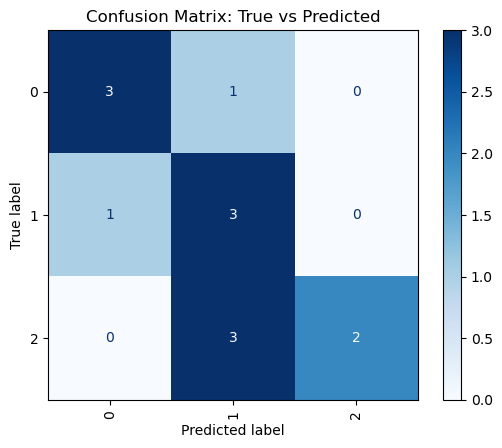

In [50]:

# Plot the matrix
disp = ConfusionMatrixDisplay.from_estimator(
    grid, 
    knn_X_test, 
    knn_y_test, 
    cmap='Blues',
    xticks_rotation='vertical' # Helps if class names are long
)

# title and show
disp.ax_.set_title("Confusion Matrix: True vs Predicted")

#output picture png 
#plt.savefig('knn_confusionMatrix.png')

#show confusion matrix 
plt.show()

# Scatterplots 
df_cat= faces_cut.copy()
#catagory for discrete colors 
df_cat['golden_score']= df_cat['golden_score'].astype("category")

eyeVsMouth = px.scatter(df_cat, x="eye_ratio", y="mouth_nose_ratio",title= "Eye Ratio vs Mouth Nose Ratio" ,color="golden_score",color_discrete_sequence=['black', "blue", 'hotpink'] ,symbol="golden_score")
faceVsEye = px.scatter(df_cat, x="face_ratio", y="eye_ratio", title="Face Ratio vs Eye Ratio",color="golden_score",color_discrete_sequence=['black', "blue", 'hotpink'] ,symbol="golden_score")
faceVsMouth = px.scatter(df_cat, x="face_ratio", y="mouth_nose_ratio",title="Face Ratio vs Mouth Nose Ratio" , color="golden_score",color_discrete_sequence=['black', "blue", 'hotpink'] ,symbol="golden_score")


eyeVsMouth.show()
faceVsMouth.show()
faceVsEye.show()

I would say that the KNN model does a pretty good job at correctly clustering items into the correct group since they accuracy is 0.846 and the balanced accuracy is 0.850. The model benefitted from splitting the golden score into 3 buckets instead of 5. I would say there is still some room for improvement.

#####################################################################################
# Kmeans
#####################################################################################

In [51]:
#kmeansmodel
X=headshots[['face_ratio', 'eye_ratio', 'mouth_nose_ratio']]
X = X.dropna()  

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init=10, random_state=123))
])
pipe.fit(X)
labels = pipe["kmeans"].labels_

headshots["cluster"] = labels.astype(str)
headshots.head()

,filename,name,email,race,gender,status,golden_score,face_ratio,mouth_nose_ratio,eye_ratio,face_height,face_width,nose_width,mouth_width,cluster
0,2025-Jon-Kropko_Sophie Kim.png,Jon Kropko,jkropko@virginia.edu,white/caucasian,male,Success,72.296905,1.265537,1.073991,2.378663,113.818867,89.937213,39.701984,42.639569,0
1,20250214_164859_Shawn Ding.jpg,Shawn Ding,NaN,asian,male,Success,65.385817,1.274937,0.840948,2.062060,575.460816,451.364018,176.880556,148.747304,0
2,7889B956-127B-4F16-8218-95F2EFBBB575_Sabine Se...,Sabine Segaloff,bhj3vc@virginia.edu,white/caucasian,female,Success,70.676671,1.229060,1.058037,2.332540,642.068678,522.406377,230.671558,244.059106,0
3,"Afriyie, Prince (pa5jg) square_Sophie Kim.png",Prince Afriyie,pa5jg@virginia.edu,black or african american,male,Success,69.104021,1.116233,1.119973,2.480829,107.956073,96.714640,43.573933,48.801633,1
4,Ana-Li MSDSR Ambassador_Anna Li.png,Anna Li,tpb3rw@virginia.edu,asian,female,Success,72.301283,1.200314,1.139356,2.402057,802.259079,668.374490,279.874979,318.877173,1


In [52]:
# elbow plot
K_values = list(range(1, 11))
wcss = []

for k in K_values:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)
    inertia = pipe["kmeans"].inertia_
    wcss.append(inertia)


fig = px.line(
    x=K_values,
    y=wcss,
    markers=True,
    title="Elbow Plot (Pipeline: StandardScaler + KMeans)",
    labels={"x": "Number of Clusters (K)", "y": "WCSS / Inertia"}
)

fig.update_layout(height=500, width=700)
fig.show()

Elbow is at 2 so two clusters is best for our dataset.

In [53]:
# silhouette graph  
sil_scores = []
K_values_sil = list(range(2, 11))

for k in K_values_sil:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)

    labels = pipe["kmeans"].labels_

    sil = silhouette_score(X, labels)

    sil_scores.append(sil)


fig = px.line(
    x=K_values_sil,
    y=sil_scores,
    markers=True,
    title="Silhouette Scores (Pipeline: StandardScaler + KMeans)",
    labels={"x": "Number of Clusters (K)", "y": "Silhouette Score"}
)

fig.update_layout(height=500, width=700)
fig.show()


Silhouette drops at 2 or 3. these would be good number of clusters.

In [54]:
fig = px.scatter(
    headshots,
    x="face_ratio",
    y="mouth_nose_ratio",
    hover_name="name",
    hover_data=["name", 'race', 'gender', 'cluster'],
    height=650,
    color = 'cluster',
    title="K-Means Clusters Across cohort"
)

fig.show()


used two clusters. This graph is limited because we build our model off of three different ratios but we can only visualize it using two. It does help us to start to see the patterns in the data.

In [55]:
headshot3 = headshots[["name", 'race', 'gender', 'cluster', "golden_score" ]]


In [56]:
cluster_gender = round(pd.crosstab(headshot3['gender'], headshot3['cluster'], normalize='columns'),2).reset_index()
cluster_gender = pd.melt(cluster_gender, id_vars = 'gender', value_vars = ["0", "1"])
cluster_gender['bar_text'] = cluster_gender['value'].astype(str)+ "%"
cluster_gender

,gender,cluster,value,bar_text
0,female,0,0.36,0.36%
1,male,0,0.64,0.64%
2,female,1,0.57,0.57%
3,male,1,0.43,0.43%


In [57]:
fig = px.bar(cluster_gender, x= 'cluster', y= 'value', color = 'gender',
                text = 'bar_text', barmode = 'group', width = 600, height = 400,
                title = "Clusters by Gender")
fig.update_layout(showlegend=True)
fig.show()

In [58]:
cluster_race = round(pd.crosstab( headshot3['cluster'],headshot3['race'], normalize='columns'),2).reset_index()
cluster_race = pd.melt(cluster_race, id_vars = 'cluster', value_vars = ['asian', 'black or african american', 'hispanic or latino',
       'middle eastern or north african', 'other/mixed', 'white/caucasian'])
cluster_race['bar_text'] = cluster_race['value'].astype(str)+ "%"
cluster_race

,cluster,race,value,bar_text
0,0,asian,0.36,0.36%
1,1,asian,0.64,0.64%
2,0,black or african american,0.29,0.29%
3,1,black or african american,0.71,0.71%
4,0,hispanic or latino,0.33,0.33%
5,1,hispanic or latino,0.67,0.67%
6,0,middle eastern or north african,0.50,0.5%
7,1,middle eastern or north african,0.50,0.5%
8,0,other/mixed,0.75,0.75%
9,1,other/mixed,0.25,0.25%


In [59]:
fig = px.bar(cluster_race,x= 'cluster', y= 'value', color = 'race',
                text = 'bar_text', barmode = 'group', width = 800, height = 400,
                title = "Clusters by Race")
fig.update_layout(showlegend=True)
fig.show()

In [60]:
#Relationship between K-Means Clusters and Golden Score
analysis_df = headshots[["name", 'race', 'gender', 'cluster', "golden_score"]].copy()
analysis_df = analysis_df.dropna(subset=['golden_score'])


In [61]:

# Golden Score by Cluster (overall)

fig1 = px.box(
    analysis_df,
    x='cluster',y='golden_score', color='cluster',
    title='Golden Score Distribution by Cluster (Overall)',
    labels={'golden_score': 'Golden Score', 'cluster': 'Cluster'},
    height=500
)
fig1.update_layout(showlegend=False)
fig1.show()



In [62]:
#Golden Score by Cluster and Gender
fig2 = px.box(
    analysis_df,
    x='cluster',
    y='golden_score',
    color='gender',
    facet_col='gender',
    title='Golden Score Distribution by Cluster and Gender',
    labels={'golden_score': 'Golden Score', 'cluster': 'Cluster'},
    height=500
)
fig2.show()


As we can see there are patterns in facial demographics that could affect the underlying proportions that go into what is deemed as the golden ratio. This is to say that the ratio itself is biased towards a specific demographic of individuals. Since our datset is quite small it is hard to draw definite conclusions.

K-means clustering is a unsupervised learning technique used to find natural patterns within the data. Our data favors using 2-3 as the number of clusters as per our silhouettte and elbow plot (not included on dashboard). We facial proportions such as face length-width, nose-mouth, and eye ditance ratios as numeric input values. Once clusters were fit we tried to see if there was correlation between the output clusters and the demographics of our sample. 
While using 2 clusters, you can see patterns of specific genders or races being correlated within different cluster. 
This leads us to believe that different races and gender are predisposed to different facial features or proportions. 
In terms of the golden ratio, this could imply that the ratio is biased and therefore an irrealistic standard in our society today 

# **PCA**

In [63]:
# scaling data

X = df[['face_height','face_width', 'nose_width', 'mouth_width']].astype(float)

# scale data bc the nose/mouth values are much smaller than face 
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# covariance matrix
cov = np.cov(X_std.T)
cov

array([[1.01960784, 1.0160355 , 1.00784179, 0.97859175],
       [1.0160355 , 1.01960784, 1.01092857, 0.98366091],
       [1.00784179, 1.01092857, 1.01960784, 0.99620182],
       [0.97859175, 0.98366091, 0.99620182, 1.01960784]])

In [64]:
# calculating eigenvalues/vectors
eigvals, eigvecs = np.linalg.eig(cov)
eigvals

array([4.01636527e+00, 5.02294681e-02, 3.22582493e-03, 8.61081279e-03])

In [65]:
eigvecs

array([[ 0.50074382,  0.44220147,  0.61896259,  0.41303607],
       [ 0.50175574,  0.35386979, -0.77113347,  0.16843551],
       [ 0.50228152,  0.01797519,  0.14906505, -0.85156901],
       [ 0.49518691, -0.82396051,  0.0042536 ,  0.27542858]])

In [66]:
# dot product
scores = X_std @ eigvecs

# creating df 
pc_df = df.copy() 
pc_df[["PC1", "PC2", "PC3", "PC4"]] = scores

pc_df

,filename,name,email,race,gender,status,golden_score,face_ratio,mouth_nose_ratio,eye_ratio,face_height,face_width,nose_width,mouth_width,PC1,PC2,PC3,PC4
0,2025-Jon-Kropko_Sophie Kim.png,Jon Kropko,jkropko@virginia.edu,white/caucasian,male,Success,72.296905,1.265537,1.073991,2.378663,113.818867,89.937213,39.701984,42.639569,-2.853872,0.011835,0.003279,-0.000647
1,20250214_164859_Shawn Ding.jpg,Shawn Ding,NaN,asian,male,Success,65.385817,1.274937,0.840948,2.062060,575.460816,451.364018,176.880556,148.747304,-1.010188,0.316471,0.027773,0.017119
2,7889B956-127B-4F16-8218-95F2EFBBB575_Sabine Se...,Sabine Segaloff,bhj3vc@virginia.edu,white/caucasian,female,Success,70.676671,1.229060,1.058037,2.332540,642.068678,522.406377,230.671558,244.059106,-0.353953,-0.031005,0.026439,-0.027037
3,"Afriyie, Prince (pa5jg) square_Sophie Kim.png",Prince Afriyie,pa5jg@virginia.edu,black or african american,male,Success,69.104021,1.116233,1.119973,2.480829,107.956073,96.714640,43.573933,48.801633,-2.818951,-0.018931,-0.015884,-0.014548
4,Ana-Li MSDSR Ambassador_Anna Li.png,Anna Li,tpb3rw@virginia.edu,asian,female,Success,72.301283,1.200314,1.139356,2.402057,802.259079,668.374490,279.874979,318.877173,0.438496,-0.101438,-0.007039,0.045502
5,Aniyah_McWilliams_Aniyah McWilliams.jpg,Aniyah McWilliams,ybf3jw@virginia.edu,black or african american,female,Success,69.880185,1.181901,1.079422,2.334260,333.552689,282.217177,132.888548,143.442829,-1.697207,-0.080139,0.000236,-0.054818
6,Erin Siedlecki Deloitte Headshot_Erin Siedleck...,Erin Siedlecki,ets6dq@virginia.edu,white/caucasian,female,Success,70.841613,1.154703,1.137731,2.303209,176.149785,152.549830,65.858780,74.929598,-2.503804,-0.025393,-0.015272,-0.004208
7,Ethan_Meidinger_Ethan Meidinger.jpeg,Ethan Meidinger,vtt4vx@virginia.edu,other/mixed,male,Success,72.944176,1.243503,1.116970,2.225552,991.276841,797.164729,349.310893,390.169929,1.297662,-0.138444,0.058649,0.016107
8,Grad Council Headshot_Marissa Burton.png,Marissa Burton,hax6fp@virginia.edu,white/caucasian,female,Success,70.491675,1.181346,1.099765,2.400286,279.023389,236.191126,103.028531,113.307156,-2.020485,-0.029925,-0.009547,-0.010973
9,Headshot_Grace George.JPG,Grace George,wcj4da@virginia.edu,asian,female,Success,69.205199,1.139413,1.100067,2.482615,1168.052014,1025.134492,434.916669,478.437385,2.389814,-0.175329,-0.091979,-0.041082


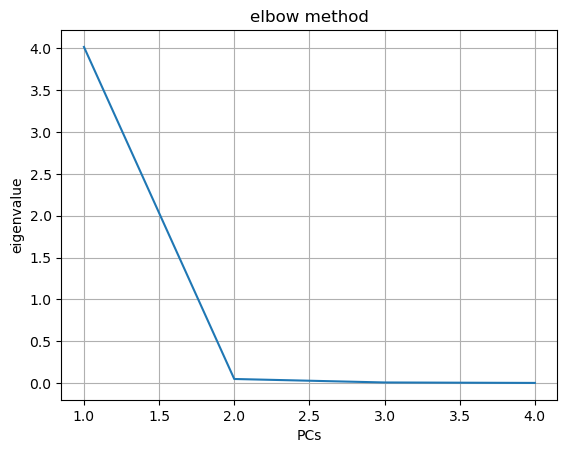

In [67]:
# what PCs to drop? elbow method
import matplotlib.pyplot as plt

# sort eigen values to ensure in right order for PCs
sorted_vals = np.sort(eigvals)[::-1]


plt.plot(range(1, 5), sorted_vals)
plt.title('elbow method')
plt.xlabel('PCs')
plt.ylabel('eigenvalue')
plt.grid(True)


plt.show()

In [68]:
# getting loadings 
loadings = eigvecs[:, :2] * np.sqrt(eigvals[:2])

# making loadings df
loading_df = pd.DataFrame(loadings,
                          index=['face_height', 'face_width', 'nose_width', 'mouth_width'], 
                          columns=["PC1_loading", "PC2_loading"])

loading_df

,PC1_loading,PC2_loading
face_height,1.003534,0.099106
face_width,1.005562,0.079309
nose_width,1.006616,0.004029
mouth_width,0.992398,-0.184665


In [69]:
# biplot!!!

fig = px.scatter(pc_df, x="PC1", y="PC2",hover_name="name",
                 title="Biplot: PC1 vs PC2")


for var in loading_df.index:
    fig.add_trace(go.Scatter(
        x=[0, loading_df.loc[var, "PC1_loading"]],
        y=[0, loading_df.loc[var, "PC2_loading"]],
        mode="lines",
        name=var,
        line=dict(width=3)
    ))

fig.update_traces(textposition="top center")
fig.update_layout(width=800, height=600)

fig.show()

### **PCA by ratios and golden score**

In [70]:
# using only the ratio and golden score variables 
X_ratio = df[['face_ratio', 'mouth_nose_ratio', 'eye_ratio', 'golden_score']]

# standardizing
scaler_shape = StandardScaler()
X_ratio_std = scaler_shape.fit_transform(X_ratio)

# PCA
cov_ratio = np.cov(X_ratio_std.T)
eigvals_ratio, eigvecs_ratio = np.linalg.eig(cov_ratio)

In [71]:
eigvals_ratio

array([ 2.13098318e+00,  1.39204206e+00, -4.17437502e-17,  5.55406133e-01])

In [72]:
eigvecs_ratio

array([[-1.59831017e-01,  7.77517290e-01, -3.83821979e-01,
        -4.71806738e-01],
       [ 6.65021481e-01,  3.93633781e-02, -6.48946721e-01,
         3.67512051e-01],
       [ 4.63248392e-01, -3.88206063e-01,  1.84552372e-12,
        -7.96678718e-01],
       [ 5.63561357e-01,  4.93166748e-01,  6.56923772e-01,
         8.73860059e-02]])

In [73]:
# dot product
scores = X_ratio_std @ eigvecs_ratio

# creating pca df 
pc_df = df.copy() # Use your original 'data' frame
pc_df[["PC1", "PC2", "PC3", "PC4"]] = scores

pc_df

,filename,name,email,race,gender,status,golden_score,face_ratio,mouth_nose_ratio,eye_ratio,face_height,face_width,nose_width,mouth_width,PC1,PC2,PC3,PC4
0,2025-Jon-Kropko_Sophie Kim.png,Jon Kropko,jkropko@virginia.edu,white/caucasian,male,Success,72.296905,1.265537,1.073991,2.378663,113.818867,89.937213,39.701984,42.639569,0.356454,0.794996,4.798937e-11,-0.597768
1,20250214_164859_Shawn Ding.jpg,Shawn Ding,NaN,asian,male,Success,65.385817,1.274937,0.840948,2.062060,575.460816,451.364018,176.880556,148.747304,-3.492845,0.890336,-4.774486e-10,0.555107
2,7889B956-127B-4F16-8218-95F2EFBBB575_Sabine Se...,Sabine Segaloff,bhj3vc@virginia.edu,white/caucasian,female,Success,70.676671,1.229060,1.058037,2.332540,642.068678,522.406377,230.671558,244.059106,-0.102340,0.271625,2.658707e-11,-0.108726
3,"Afriyie, Prince (pa5jg) square_Sophie Kim.png",Prince Afriyie,pa5jg@virginia.edu,black or african american,male,Success,69.104021,1.116233,1.119973,2.480829,107.956073,96.714640,43.573933,48.801633,0.888513,-1.788071,-1.790754e-11,-0.139008
4,Ana-Li MSDSR Ambassador_Anna Li.png,Anna Li,tpb3rw@virginia.edu,asian,female,Success,72.301283,1.200314,1.139356,2.402057,802.259079,668.374490,279.874979,318.877173,1.009955,-0.043950,2.595715e-11,-0.062981
5,Aniyah_McWilliams_Aniyah McWilliams.jpg,Aniyah McWilliams,ybf3jw@virginia.edu,black or african american,female,Success,69.880185,1.181901,1.079422,2.334260,333.552689,282.217177,132.888548,143.442829,0.019996,-0.408617,6.307021e-12,0.275202
6,Erin Siedlecki Deloitte Headshot_Erin Siedleck...,Erin Siedlecki,ets6dq@virginia.edu,white/caucasian,female,Success,70.841613,1.154703,1.137731,2.303209,176.149785,152.549830,65.858780,74.929598,0.476132,-0.471809,1.368386e-12,0.908367
7,Ethan_Meidinger_Ethan Meidinger.jpeg,Ethan Meidinger,vtt4vx@virginia.edu,other/mixed,male,Success,72.944176,1.243503,1.116970,2.225552,991.276841,797.164729,349.310893,390.169929,0.165637,1.152957,4.125614e-11,0.779284
8,Grad Council Headshot_Marissa Burton.png,Marissa Burton,hax6fp@virginia.edu,white/caucasian,female,Success,70.491675,1.181346,1.099765,2.400286,279.023389,236.191126,103.028531,113.307156,0.510536,-0.541472,1.027278e-11,-0.091717
9,Headshot_Grace George.JPG,Grace George,wcj4da@virginia.edu,asian,female,Success,69.205199,1.139413,1.100067,2.482615,1168.052014,1025.134492,434.916669,478.437385,0.733896,-1.507808,-9.370018e-12,-0.384872


In [74]:
# getting loadings
loadings = eigvecs_ratio[:, :2] * np.sqrt(eigvals_ratio[:2])

# create loadings df 
loading_df = pd.DataFrame(loadings,
                          index=['face_ratio', 'mouth_nose_ratio', 'eye_ratio', 'golden_score'], 
                          columns=["PC1_loading", "PC2_loading"])

loading_df

,PC1_loading,PC2_loading
face_ratio,-0.233320,0.917352
mouth_nose_ratio,0.970791,0.046443
eye_ratio,0.676245,-0.458024
golden_score,0.822681,0.581862


In [75]:
# biplot of PCA w/ ratio and golden score variables
fig = px.scatter(pc_df, x="PC1", y="PC2",hover_name="name",
                 title="Biplot: PC1 vs PC2")


for var in loading_df.index:
    fig.add_trace(go.Scatter(
        x=[0, loading_df.loc[var, "PC1_loading"]],
        y=[0, loading_df.loc[var, "PC2_loading"]],
        mode="lines",
        name=var,
        line=dict(width=3)
    ))

fig.update_traces(textposition="top center")
fig.update_layout(width=800, height=600)

fig.show()

#### **Conclusions for PCA**

***Size & Dimensions PCA***
                                 
The Size & Dimensions PCA model answers the question of how proportional the individual's face is. Based on the biplot, PC1 describes the 'largeness' of one's face. The left side of the x axis indicates people with smaller faces (aka small face height, small face width, small nose width and small mouth width), and the right side of the x axis indicates the opposite. The PC2 in this case mostly showcases the proportion of mouth width to face size. In other words, the top of the y axis indicates a larger face with a relatively narrow mouth, and the bottom of the y axis indicates a smaller face with a relatively wider mouth. The closer the point is to (0,0), the more proportional the mouth width is to face size. 

                                 
***Ratios & Golden Score PCA***
                                 

The Ratio & Golden Score PCA model answers the question of which face ratio and feature ratios are most ideal to fit the golden ratio. Based on the biplot, PC1 describes the relationship of the golden score based on the mouth vs nose ratio. The right side of the x axis indicates wider features, namely a wider mouth than nose. Because the golden score line is also pointing to the right, the right side of the x axis also indicates a higher golden score. The left side of the x axis indicates a wider nose than mouth and a lower golden score. PC2 indicates the face length, with the top of the y axis being longer faces and the bottom of the y axis being shorter faces. There is also the contribution of the eye_ratio variable (which didn't contribute to the golden score), which also shows in the PC2 plot as shorter faces typically having wider set eyes.
                            
                                 
The top right of the biplot indicates faces that are the closest to the golden ratio. These faces are typically longer (based on PC2) and more balanced nose/mouth ratio (though leaning more towards a wider mouth versus nose). The top left of the biplot indicates faces that are longer, but have more narrow features, particularly a wider nose than mouth. The bottom right of the biplot indicates shorter faces with wider features (particuarly wider eyes and wider mouth). The bottom right has particuarly good golden scores, but not as good as the top right. The bottom left of the biplot indicates faces that are shorter and have more narrow set features, meaning they have the smallest golden scores. In summary, the golden score is the highest for longer faces that have wider features, particularly a wider nose than mouth. 
                    